In [1]:
pip install medmnist timm torch torchvision -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import os
import requests
import zipfile
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import medmnist


In [19]:
random_seed = 42

In [3]:
class NumpyDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = (image * 255).astype(np.uint8)
        label = int(label) # int label 1d

        # CHW
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
path = '/home/dime/Downloads/Pre-thesis/data/dermamnist_224'

In [6]:
from collections import Counter

def compute_class_counts(labels_path):
    labels = np.load(labels_path).flatten()  
    return dict(Counter(labels))  

In [8]:
img_size=224
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

In [9]:
def load_datasets(batch_size=32, img_size=224):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [10]:
train_class_counts = compute_class_counts(os.path.join(path, 'train_labels.npy'))
val_class_counts = compute_class_counts(os.path.join(path, 'val_labels.npy'))
test_class_counts = compute_class_counts(os.path.join(path, 'test_labels.npy'))

print('Train class counts:', train_class_counts)
print('Val class counts:', val_class_counts)
print('Test class counts:', test_class_counts)

Train class counts: {0: 228, 5: 4693, 4: 779, 2: 769, 1: 359, 6: 99, 3: 80}
Val class counts: {5: 671, 4: 111, 2: 110, 6: 14, 1: 52, 0: 33, 3: 12}
Test class counts: {5: 1341, 3: 23, 4: 223, 0: 66, 2: 220, 1: 103, 6: 29}


In [11]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = create_model('vit_large_patch16_224', pretrained=True, num_classes=num_classes)

        self.vit.head = nn.Sequential(
            nn.Dropout(0.5),
            self.vit.head
        )

    def forward(self, x):
        return self.vit(x)

In [12]:
def plot_metrics(metrics_log):
    epochs = range(1, len(metrics_log["train_loss"]) + 1)

    # Plot loss
    plt.figure()
    plt.plot(epochs, metrics_log["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics_log["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, metrics_log["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics_log["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.show()

    # Plot F1 score
    plt.figure()
    plt.plot(epochs, metrics_log["train_f1"], label="Train F1 Score")
    plt.plot(epochs, metrics_log["val_f1"], label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Epochs")
    plt.legend()
    plt.show()

In [13]:
num_epochs = 30
learning_rate = 0.001

def train_model(model, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate):
    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []    
    }

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss /= len(val_loader)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    
    print(f"  Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"  Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"  Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"  Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"  Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"  Final Val F1: {metrics_log['val_f1'][-1]:.4f}")
    plot_metrics(metrics_log)
    return metrics_log

Training Epoch 1/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [1/30]:
  Train Loss: 1.5734, Accuracy: 0.6225, F1: 0.5287
  Val Loss: 1.1688, Accuracy: 0.6690, F1: 0.5363


Training Epoch 2/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [2/30]:
  Train Loss: 1.1982, Accuracy: 0.6689, F1: 0.5369
  Val Loss: 1.2260, Accuracy: 0.6690, F1: 0.5363


Training Epoch 3/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [3/30]:
  Train Loss: 1.1724, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1613, Accuracy: 0.6690, F1: 0.5363


Training Epoch 4/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [4/30]:
  Train Loss: 1.1666, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1827, Accuracy: 0.6690, F1: 0.5363


Training Epoch 5/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [5/30]:
  Train Loss: 1.1660, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1365, Accuracy: 0.6690, F1: 0.5363


Training Epoch 6/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [6/30]:
  Train Loss: 1.1560, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1479, Accuracy: 0.6690, F1: 0.5363


Training Epoch 7/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [7/30]:
  Train Loss: 1.1588, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1496, Accuracy: 0.6690, F1: 0.5363


Training Epoch 8/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [8/30]:
  Train Loss: 1.1547, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1398, Accuracy: 0.6690, F1: 0.5363


Training Epoch 9/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [9/30]:
  Train Loss: 1.1553, Accuracy: 0.6695, F1: 0.5375
  Val Loss: 1.1643, Accuracy: 0.6690, F1: 0.5363


Training Epoch 10/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [10/30]:
  Train Loss: 1.1499, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1669, Accuracy: 0.6690, F1: 0.5363


Training Epoch 11/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [11/30]:
  Train Loss: 1.1516, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1401, Accuracy: 0.6690, F1: 0.5363


Training Epoch 12/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [12/30]:
  Train Loss: 1.1526, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1417, Accuracy: 0.6690, F1: 0.5363


Training Epoch 13/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [13/30]:
  Train Loss: 1.1460, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1371, Accuracy: 0.6690, F1: 0.5363


Training Epoch 14/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [14/30]:
  Train Loss: 1.1427, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1373, Accuracy: 0.6690, F1: 0.5363


Training Epoch 15/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [15/30]:
  Train Loss: 1.1421, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1351, Accuracy: 0.6690, F1: 0.5363


Training Epoch 16/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [16/30]:
  Train Loss: 1.1462, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1316, Accuracy: 0.6690, F1: 0.5363


Training Epoch 17/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [17/30]:
  Train Loss: 1.1456, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1353, Accuracy: 0.6690, F1: 0.5363


Training Epoch 18/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [18/30]:
  Train Loss: 1.1412, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1390, Accuracy: 0.6690, F1: 0.5363


Training Epoch 19/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [19/30]:
  Train Loss: 1.1384, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1322, Accuracy: 0.6690, F1: 0.5363


Training Epoch 20/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [20/30]:
  Train Loss: 1.1395, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1307, Accuracy: 0.6690, F1: 0.5363


Training Epoch 21/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [21/30]:
  Train Loss: 1.1370, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1315, Accuracy: 0.6690, F1: 0.5363


Training Epoch 22/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [22/30]:
  Train Loss: 1.1378, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1294, Accuracy: 0.6690, F1: 0.5363


Training Epoch 23/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [23/30]:
  Train Loss: 1.1349, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1303, Accuracy: 0.6690, F1: 0.5363


Training Epoch 24/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [24/30]:
  Train Loss: 1.1362, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1299, Accuracy: 0.6690, F1: 0.5363


Training Epoch 25/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [25/30]:
  Train Loss: 1.1335, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1287, Accuracy: 0.6690, F1: 0.5363


Training Epoch 26/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [26/30]:
  Train Loss: 1.1314, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1282, Accuracy: 0.6690, F1: 0.5363


Training Epoch 27/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [27/30]:
  Train Loss: 1.1328, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1278, Accuracy: 0.6690, F1: 0.5363


Training Epoch 28/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [28/30]:
  Train Loss: 1.1296, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1281, Accuracy: 0.6690, F1: 0.5363


Training Epoch 29/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [29/30]:
  Train Loss: 1.1304, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1283, Accuracy: 0.6690, F1: 0.5363


Training Epoch 30/30:   0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms fro

Epoch [30/30]:
  Train Loss: 1.1305, Accuracy: 0.6698, F1: 0.5373
  Val Loss: 1.1243, Accuracy: 0.6690, F1: 0.5363
  Final Train Loss: 1.1305
  Final Train Accuracy: 0.6698
  Final Train F1: 0.5373
  Final Val Loss: 1.1243
  Final Val Accuracy: 0.6690
  Final Val F1: 0.5363


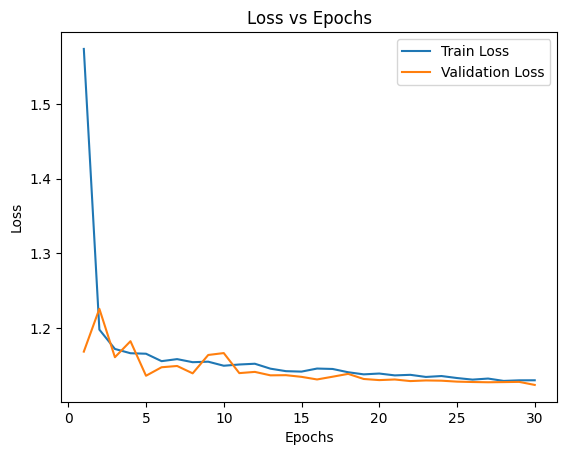

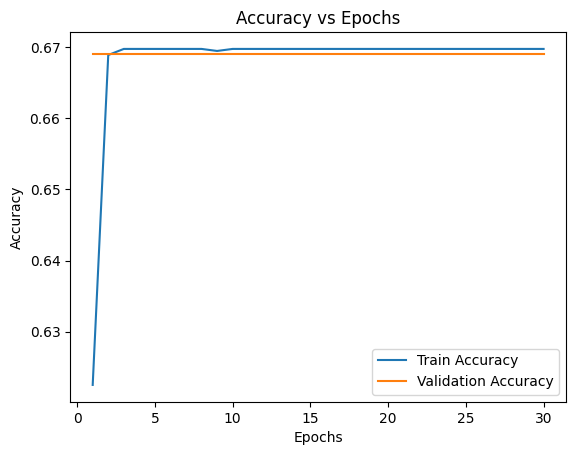

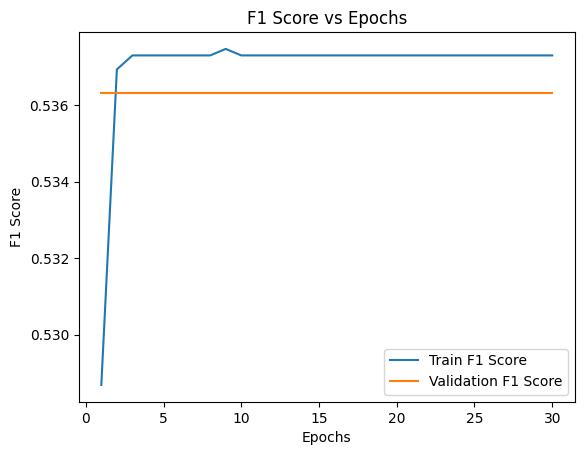

In [14]:
if __name__ == "__main__":
    batch_size = 32
    img_size = 224

    train_loader, val_loader, test_loader = load_datasets(batch_size, img_size)

    num_classes = 7

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTModel(num_classes=num_classes)

    train_model(model, train_loader, val_loader, device, num_epochs, learning_rate)

In [15]:
#save model 
torch.save(model.state_dict(), '/home/dime/Downloads/Pre-thesis/data/dermamnist_224/vit_model.pth')

## 10%

In [30]:
def subset_dataset_percentage(dataset, labels_path, percentage=10, seed=42):
    random.seed(seed)
    labels = np.load(labels_path).flatten()
    class_indices = defaultdict(list)

    for idx, label in enumerate(labels):
        class_indices[label].append(idx)
    
    subset_indices = []
    for indices in class_indices.values():
        subset_size = max(1, len(indices) * percentage // 100)
        subset_indices.extend(random.sample(indices, subset_size))
    
    return Subset(dataset, subset_indices)

def load_data_subset(batch_size=32, img_size=224):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_subset = subset_dataset_percentage(train_dataset, os.path.join(path, 'train_labels.npy'), percentage=10, seed=42)
    val_subset = val_dataset
    test_subset = test_dataset

    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader_subset = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader_subset, val_loader_subset, test_loader_subset   

In [28]:
num_epochs = 30
learning_rate = 0.0001

def train_subset_model(model, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate):
    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []    
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss /= len(val_loader)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    
    print(f"  Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"  Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"  Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"  Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"  Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"  Final Val F1: {metrics_log['val_f1'][-1]:.4f}")
    plot_metrics(metrics_log)
    return metrics_log

Training Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [1/30]:
  Train Loss: 1.8828, Accuracy: 0.5330, F1: 0.5055
  Val Loss: 1.1385, Accuracy: 0.6690, F1: 0.5363


Training Epoch 2/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [2/30]:
  Train Loss: 1.2200, Accuracy: 0.6652, F1: 0.5427
  Val Loss: 1.2053, Accuracy: 0.6690, F1: 0.5363


Training Epoch 3/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [3/30]:
  Train Loss: 1.1904, Accuracy: 0.6695, F1: 0.5434
  Val Loss: 1.1629, Accuracy: 0.6690, F1: 0.5363


Training Epoch 4/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [4/30]:
  Train Loss: 1.1943, Accuracy: 0.6724, F1: 0.5419
  Val Loss: 1.1520, Accuracy: 0.6690, F1: 0.5363


Training Epoch 5/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [5/30]:
  Train Loss: 1.1681, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1586, Accuracy: 0.6690, F1: 0.5363


Training Epoch 6/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [6/30]:
  Train Loss: 1.1846, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1546, Accuracy: 0.6690, F1: 0.5363


Training Epoch 7/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [7/30]:
  Train Loss: 1.1586, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1376, Accuracy: 0.6690, F1: 0.5363


Training Epoch 8/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [8/30]:
  Train Loss: 1.1556, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1338, Accuracy: 0.6690, F1: 0.5363


Training Epoch 9/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [9/30]:
  Train Loss: 1.1744, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1382, Accuracy: 0.6690, F1: 0.5363


Training Epoch 10/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [10/30]:
  Train Loss: 1.1759, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1289, Accuracy: 0.6690, F1: 0.5363


Training Epoch 11/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [11/30]:
  Train Loss: 1.1603, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1342, Accuracy: 0.6690, F1: 0.5363


Training Epoch 12/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [12/30]:
  Train Loss: 1.1579, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1387, Accuracy: 0.6690, F1: 0.5363


Training Epoch 13/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [13/30]:
  Train Loss: 1.1468, Accuracy: 0.6724, F1: 0.5419
  Val Loss: 1.1365, Accuracy: 0.6690, F1: 0.5363


Training Epoch 14/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [14/30]:
  Train Loss: 1.1634, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1373, Accuracy: 0.6690, F1: 0.5363


Training Epoch 15/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [15/30]:
  Train Loss: 1.1424, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1385, Accuracy: 0.6690, F1: 0.5363


Training Epoch 16/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [16/30]:
  Train Loss: 1.1599, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1320, Accuracy: 0.6690, F1: 0.5363


Training Epoch 17/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [17/30]:
  Train Loss: 1.1386, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1340, Accuracy: 0.6690, F1: 0.5363


Training Epoch 18/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [18/30]:
  Train Loss: 1.1531, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1324, Accuracy: 0.6690, F1: 0.5363


Training Epoch 19/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [19/30]:
  Train Loss: 1.1483, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1267, Accuracy: 0.6690, F1: 0.5363


Training Epoch 20/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [20/30]:
  Train Loss: 1.1418, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1341, Accuracy: 0.6690, F1: 0.5363


Training Epoch 21/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [21/30]:
  Train Loss: 1.1249, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1318, Accuracy: 0.6690, F1: 0.5363


Training Epoch 22/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [22/30]:
  Train Loss: 1.1369, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1276, Accuracy: 0.6690, F1: 0.5363


Training Epoch 23/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [23/30]:
  Train Loss: 1.1484, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1297, Accuracy: 0.6690, F1: 0.5363


Training Epoch 24/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [24/30]:
  Train Loss: 1.1383, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1247, Accuracy: 0.6690, F1: 0.5363


Training Epoch 25/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [25/30]:
  Train Loss: 1.1299, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1263, Accuracy: 0.6690, F1: 0.5363


Training Epoch 26/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [26/30]:
  Train Loss: 1.1391, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1308, Accuracy: 0.6680, F1: 0.5358


Training Epoch 27/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [27/30]:
  Train Loss: 1.1293, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1286, Accuracy: 0.6690, F1: 0.5363


Training Epoch 28/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [28/30]:
  Train Loss: 1.1118, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1266, Accuracy: 0.6680, F1: 0.5358


Training Epoch 29/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [29/30]:
  Train Loss: 1.1231, Accuracy: 0.6724, F1: 0.5419
  Val Loss: 1.1262, Accuracy: 0.6680, F1: 0.5358


Training Epoch 30/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_12132/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from

Epoch [30/30]:
  Train Loss: 1.1289, Accuracy: 0.6739, F1: 0.5426
  Val Loss: 1.1243, Accuracy: 0.6690, F1: 0.5363
  Final Train Loss: 1.1289
  Final Train Accuracy: 0.6739
  Final Train F1: 0.5426
  Final Val Loss: 1.1243
  Final Val Accuracy: 0.6690
  Final Val F1: 0.5363


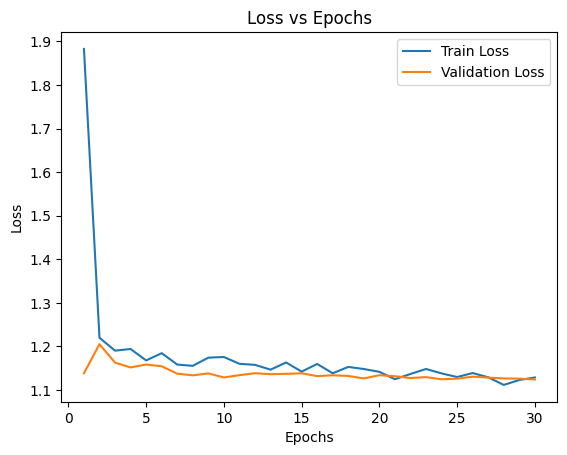

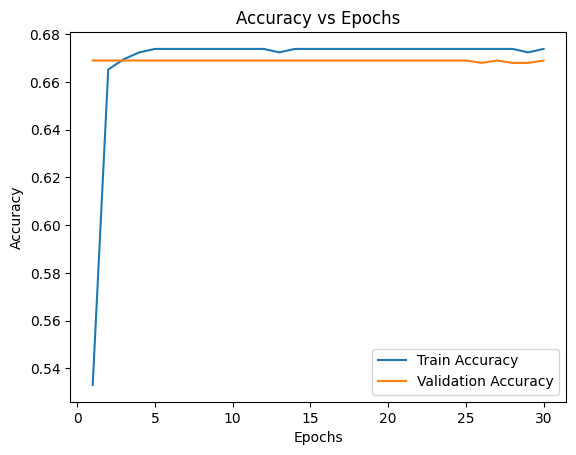

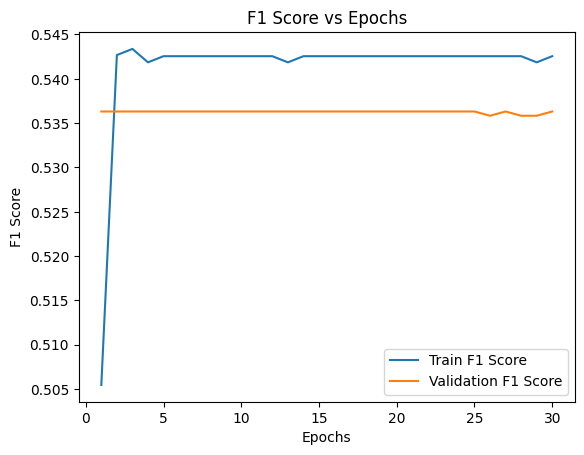

In [33]:
if __name__ == "__main__":
    batch_size = 32
    img_size = 224

    train_subset_loader, val_subset_loader, test_subset_loader = load_data_subset(batch_size, img_size)

    num_classes = 7

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTModel(num_classes=num_classes)

    train_subset_model(model, train_subset_loader, val_subset_loader, device, num_epochs, learning_rate)